## Imports & Setup

In [13]:
import setup

setup.main()

import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs
import matplotlib.pyplot as plt
import numpy as np
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.pullback_metric import PullbackDiffeoMetric, PullbackMetric
from viz import plot_grids

import neurometry.datasets.gridcells as gridcells

%load_ext autoreload
%autoreload 2
%matplotlib inline

Working directory:  /Users/facosta/Desktop/code/neurometry/neurometry/neuralwarp
Directory added to path:  /Users/facosta/Desktop/code/neurometry/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry/neurometry/neuralwarp
['/Users/facosta/Desktop/code/neurometry/neurometry/neuralwarp', '/Users/facosta/miniconda3/envs/neurometry/lib/python38.zip', '/Users/facosta/miniconda3/envs/neurometry/lib/python3.8', '/Users/facosta/miniconda3/envs/neurometry/lib/python3.8/lib-dynload', '', '/Users/facosta/miniconda3/envs/neurometry/lib/python3.8/site-packages', '/Users/facosta/Desktop/code/neurometry', '/Users/facosta/Desktop/code/neurometry/neurometry', '/Users/facosta/Desktop/code/neurometry/neurometry/neuralwarp', '/Users/facosta/Desktop/code/neurometry', '/Users/facosta/Desktop/code/neurometry/neurometry', '/Users/facosta/Desktop/code/neurometry/neurometry/neuralwarp']


## Hyperbolic Geometry

In [14]:
H2 = Hyperboloid(dim=2)


def convert_to_poincare_coordinates(points):
    return points[1:] / (1 + points[:1])


def hyperbolic_warp(point):
    extrinsic_point = H2.from_coordinates(point, "intrinsic")
    return convert_to_poincare_coordinates(extrinsic_point)


warp = hyperbolic_warp

In [16]:
# old geomstats
pullback_metric = PullbackMetric(dim=2, embedding_dim=2, immersion=warp)

In [15]:
# new geomstats
class PlaneWarpMetric(PullbackDiffeoMetric):
    def __init__(self):
        super().__init__(space=Euclidean(dim=2))

    def _define_embedding_space(self):
        return Euclidean(dim=2)

    def diffeomorphism(self, base_point):
        return warp(base_point)

    def inverse_diffeomorphism(self, base_point):
        return warp(base_point)


pullback_metric = PlaneWarpMetric()

TypeError: Can't instantiate abstract class PlaneWarpMetric with abstract methods define_embedding_metric

In [5]:
point_a = gs.array([0.0, 0.0])
point_b = gs.array([1.0, 1.0])
pullback_metric.dist(point_a, point_b)

tensor(0.5221)

## Plot volume element $\sqrt{|\text{det}(g)|}$

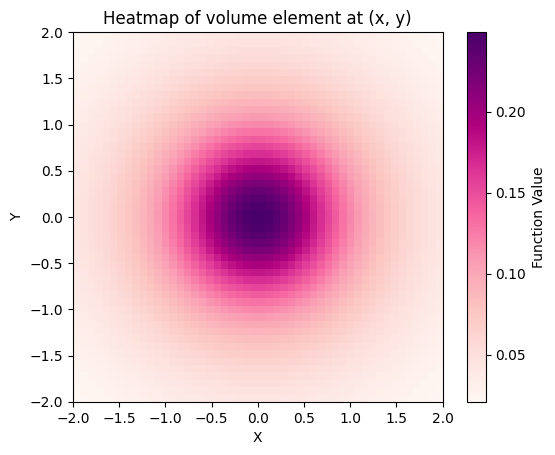

In [7]:
x = gs.linspace(-2, 2, 50)
y = gs.linspace(-2, 2, 50)
x_grid, y_grid = gs.meshgrid(x, y)


# Combine and reshape the x and y coordinates into a list of 2D points
points = gs.vstack((x_grid.ravel(), y_grid.ravel())).T


# Define your function
def volume_element(x, y):
    point = gs.array([x, y])
    g = pullback_metric.metric_matrix(point)
    return gs.sqrt(gs.abs(gs.linalg.det(g)))


# Apply the function to each point in the list
values = gs.array([volume_element(x, y) for x, y in points])

# Reshape the values back into a 2D grid
z_values = values.reshape(x_grid.shape)

# Create the heatmap
plt.imshow(
    z_values, origin="lower", extent=[x.min(), x.max(), y.min(), y.max()], cmap="RdPu"
)
plt.colorbar(label="Function Value")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Heatmap of volume element at (x, y)")
plt.show()

## Visualize geodesic grid

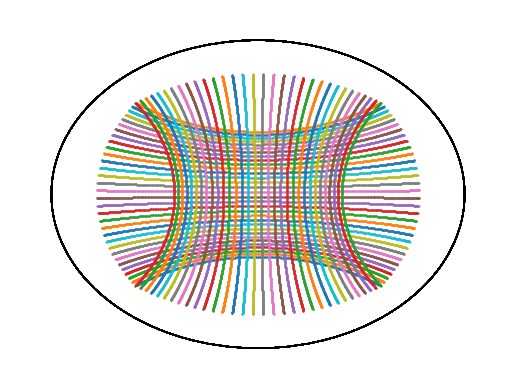

In [11]:
"""Plot a grid on H2 with Poincare Disk visualization."""

import geomstats.backend as gs
import geomstats.visualization as visualization
import matplotlib.pyplot as plt
from geomstats.geometry.hyperboloid import Hyperboloid

H2 = Hyperboloid(dim=2)
METRIC = H2.metric

# from geomstats.geometry.euclidean import Euclidean

# R2 = Euclidean(dim=2)
# METRIC = R2.metric

left = -4.0
right = 4.0
bottom = -4.0
top = 4.0
grid_size = 32
n_steps = 512


"""Plot a grid on H2 with Poincare Disk visualization.

Parameters
----------
left, right, bottom, top : ints
    Grid's coordinates
grid_size : int
    Grid's size.
n_steps : int
    Number of steps along the geodesics defining the grid.
"""
starts = []
ends = []
for p in gs.linspace(left, right, grid_size):
    starts.append(gs.array([top, p]))
    ends.append(gs.array([bottom, p]))
for p in gs.linspace(top, bottom, grid_size):
    starts.append(gs.array([p, left]))
    ends.append(gs.array([p, right]))

starts = [H2.from_coordinates(s, "intrinsic") for s in starts]
ends = [H2.from_coordinates(e, "intrinsic") for e in ends]
ax = plt.gca()
for start, end in zip(starts, ends, strict=False):
    geodesic = METRIC.geodesic(initial_point=start, end_point=end)

    t = gs.linspace(0.0, 1.0, n_steps)
    points_to_plot = geodesic(t)
    visualization.plot(points_to_plot, ax=ax, space="H2_poincare_disk", marker=".", s=1)

In [ ]:
from geomstats.geometry.hyperboloid import Hyperboloid

H2 = Hyperboloid(dim=2)


def hyperbolic_wrap(s):
    return H2.from_coordinates(s, "intrinsic")

In [ ]:
visualization.plot(points_to_plot, ax=ax, space="H2_poincare_disk", marker=".", s=1)

In [ ]:
from geomstats.geometry.poincare_ball import PoincareBall

H2 = PoincareBall(dim=2)


def hyperbolic_wrap(point):
    return H2.change_coordinates_system(
        point, from_coordinates_system="intrinsic", to_coordinates_system="ball"
    )

In [ ]:
from geomstats.geometry.hyperboloid import Hyperboloid

H2 = Hyperboloid(dim=2)  # extrinsic coordinates


def convert_to_poincare_coordinates(points):
    return points[1:] / (1 + points[:1])


#     def convert_to_klein_coordinates(points):
#         poincare_coords = points[:, 1:] / (1 + points[:, :1])
#         poincare_radius = gs.linalg.norm(poincare_coords, axis=1)
#         poincare_angle = gs.arctan2(poincare_coords[:, 1], poincare_coords[:, 0])

#         klein_radius = 2 * poincare_radius / (1 + poincare_radius**2)
#         klein_angle = poincare_angle

#         coords_0 = gs.expand_dims(klein_radius * gs.cos(klein_angle), axis=1)
#         coords_1 = gs.expand_dims(klein_radius * gs.sin(klein_angle), axis=1)
#         klein_coords = gs.concatenate([coords_0, coords_1], axis=1)
#         return klein_coords


def convert_to_klein_coordinates(points):
    """Convert from extrinsic to klein coordinates."""
    poincare_coords = points[1:] / (1 + points[:1])
    poincare_radius = gs.linalg.norm(poincare_coords)
    poincare_angle = gs.arctan2(poincare_coords[1], poincare_coords[0])

    klein_radius = 2 * poincare_radius / (1 + poincare_radius**2)
    klein_angle = poincare_angle

    coords_0 = klein_radius * gs.cos(klein_angle)
    coords_1 = klein_radius * gs.sin(klein_angle)
    return gs.array([coords_0, coords_1])


def hyperbolic_wrap(point):
    """Hyperbolic wrap happens in two steps:
    - convert from intrinsic to extrinsic
    - convert from extrinsic to klein/poincare**
    """
    extrinsic_point = H2.from_coordinates(point, "intrinsic")
    return convert_to_klein_coordinates(extrinsic_point)

## Plot grids on hyperbolic space

In [17]:
grids, grids_warped = gridcells.generate_all_grids(
    grid_scale,
    lx,
    ly,
    arena_dims,
    n_cells,
    grid_orientation_mean,
    grid_orientation_std,
    warp=hyperbolic_wrap,
    lattice_type="square",
)

NameError: name 'lx' is not defined

In [ ]:
plot_grids(grids, arena_dims)
plot_grids(grids_warped, arena_dims)

In [9]:
# import neurometry.datasets.structures as structures
import neurometry.datasets.gridcells as gridcells

scale = 1
lattice_type = "hexagonal"
dimensions = np.array([4, 4])
n_cells = 1

# lattice = structures.get_lattice(scale,lattice_type,dimensions)

In [12]:
grids, grids_warped = gridcells.generate_all_grids(
    scale, dimensions, n_cells, warp=hyperbolic_warp, lattice_type="square"
)

NameError: name 'lx' is not defined